0.00244
4.599195772074769 0.02443785005020133
3456.2364312544805 894.1629974369332 0.49292774606107453 823
+
3458.1180419131842 894.011410239875 0.492844180161354 823
+
3459.9998907431254 893.8599310483571 0.49276067380215083 823
+
3461.88197770093 893.7085597371743 0.4926772269144431 823
+
3467.9472030057163 894.6363710611506 0.49318870406794707 822
+
3469.831677605569 894.4849393038464 0.4931052238579361 822
+
3471.7163902326097 894.3336152486455 0.49302180302116605 822
+
3473.6013408435606 894.1823987709167 0.49293844148893107 822
+
3479.6922189591155 895.1131578626278 0.4934515436666303 821
+
3481.5795639039675 894.961880112463 0.4933681483565676 821
+
3483.4671467324188 894.8107097630631 0.49328481225362597 821
+
3485.354967401296 894.6596466903678 0.4932015352894145 821
+
3493.3143751761686 901.3070055231597 0.4939768447575895 819
+
3495.205905701723 901.1549964433292 0.49389353356044036 819
+
3497.0976743143615 901.003095091431 0.49381028140544175 819
+
3498.98968097095 900.8513

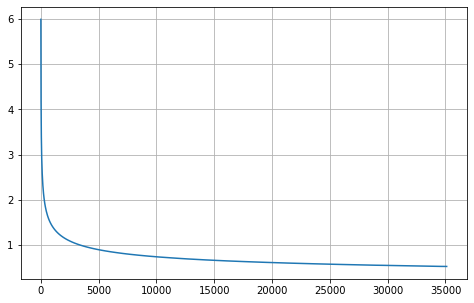

In [1]:
#Расчёт пластинчатого ТО (волны-sandia)
import matplotlib.pyplot as pt
import numpy as n
import json, CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI as p
CP.set_config_string(CP.ALTERNATIVE_REFPROP_PATH, 'C:\\maximov\\REFPROP\\')
from scipy.optimize import root

#исходные данные:

G2 =16.5347

T22 = 152.856

T21 = 50.4371
T11 =263
T12 =60
G1 = 30.1764
Q = 5880
Q=Q*1000
P11=700000
P21=30000000
P12 = P11
P22 = P21

#Геометрия
delta = 0.0015      #толщина металла
hc = 0.00094        #высота канала
wpl = 1             #ширина пластины
wc = wpl/1.254      #ширина проходного сечения
fprohc = wc*hc      #проходное сечение 1 пластины
dh =0.00109         #характерный размер
hpl = hc+delta      #высота пластины
lambdaw = 20        #теплопроводность металла

N = 3               #Число ходов холодной пластины
print(hpl)
CO2 = 'REFPROP::CO2'
O2 = 'REFPROP::Oxygen' #!
H2O = 'REFPROP::WATER'
ro11 = p('D','T', T11+273.15, 'P', P11, O2)
ro12 = p('D','T', T12+273.15, 'P', P12, O2)
ro21 = p('D','T', T21+273.15, 'P', P21, CO2)
ro22 = p('D','T', T22+273.15, 'P', P22, CO2)
ro1 = (ro11+ro12)/2
ro2 = (ro21+ro22)/2
nu11 = p('V','T', T11+273.15, 'P', P11, O2)/ro11
nu12 = p('V','T', T12+273.15, 'P', P12, O2)/ro12
nu21 = p('V','T', T21+273.15, 'P', P21, CO2)/ro21
nu22 = p('V','T', T22+273.15, 'P', P22, CO2)/ro22
nu1 = (nu11+nu12)/2
nu2 = (nu21+nu22)/2
lambda11 = p('L','T', T11+273.15, 'P', P11, O2)
lambda12 = p('L','T', T12+273.15, 'P', P12, O2)
lambda21 = p('L','T', T21+273.15, 'P', P21, CO2)
lambda22 = p('L','T', T22+273.15, 'P', P22, CO2)
lambda1 = (lambda11+lambda12)/2
lambda2 = (lambda21+lambda22)/2
Pr11 = p('PRANDTL','T', T11+273.15, 'P', P11, O2)
Pr12 = p('PRANDTL','T', T12+273.15, 'P', P12, O2)
Pr21 = p('PRANDTL','T', T21+273.15, 'P', P21, CO2)
Pr22 = p('PRANDTL','T', T22+273.15, 'P', P22, CO2)
Pr1 = (Pr11+Pr12)/2
Pr2 = (Pr21+Pr22)/2

dTmax = T11 - T22
dTmin = T12 - T21
dT = (dTmax - dTmin) / (n.log(dTmax / dTmin))*0.8            #
##############################################

print(G1/ro1,G2/ro2)
dP = n.zeros(100000)
Vv = n.zeros(100000)
i=0
for w1 in n.arange(0.01,200,0.005):
    Fproh1 = G1/(ro1*w1)            
    Npl1 = round(Fproh1/fprohc)
    Npl2 = round(Npl1 /2)
    Nsumm = Npl1+Npl2
    Fproh2 = Npl2*fprohc/N                                  #/N
    w2 = G2/(ro2*Fproh2)

    Re1 = w1*dh/nu1
    Re2 = w2*dh/nu2
    Nu1 = 0.1740*Re1**0.593*Pr1**0.430
    Nu2 = 0.1740*Re2**0.593*Pr2**0.430
    f1 = 0.4545*Re1**-0.405
    f2 = 0.4545*Re2**-0.405
    alpha1 = Nu1*lambda1/dh
    alpha2 = Nu2*lambda2/dh
    
    #K = 1/((1/alpha1)+(delta/lambdaw)+(1/alpha2))
    #F = Q/(K*dT)
    #Fl = Nsumm*(1.905)/2
    #L = F/Fl
    
    KF = Q/dT
    def func(x):
        L=x
        a1 = 1/KF
        F1 = Npl1*L*(1.905)
        F2 = Npl2*L*(1.905/N)*N                            #/N *N
        a2 = 1/(alpha1*F1)
        a3 = delta/(lambdaw*((F1+F2)/2))
        a4 = 1/(alpha2*F2)
        return a1-a2-a3-a4
    sol = root(func, 0.002)
    x=sol.x
    L=float(x)
    
    
    W = wpl
    H = hpl*Nsumm
    dP1 = f1*L/dh*ro1*w1**2/2
    dP2 = f2*L/dh*ro2*w2**2/2    *N                       #*N 
    V=L*W*H
    if round(dP1/1000,1)==round(0.005*P11/1000,2):
        print(dP1,dP2,L, Nsumm)
        print('+')
    if round(dP1/1000,1)==round(0.01*P11/1000,2):
        print(dP1,dP2,L, Nsumm)
        print('+')
    if round(dP1/1000,1)==round(0.02*P11/1000,2):
        print(dP1,dP2,L, Nsumm)
        print('+')
    if round(dP1/1000,1)==round(0.03*P11/1000,2):
        print(dP1,dP2,L, Nsumm)
        print('+')
    #if round(dP1/10000,1)==round(120000/10000,1):
    #    print(dP1,dP2,L, Nsumm)
    #    print('+')
    dP[i] = dP1
    Vv[i]=V
    i=i+1
    if dP1>0.05*P11:
        break;

imax=i
x = [dP[i] for i in range(100,imax)]
y = [Vv[i] for i in range(100,imax)]
pt.figure(figsize=(8, 5))
pt.plot(x, y)
pt.grid(True)
#pt.ylim([0,100])
#pt.xlim([1000,2*10**5])
pt.show()

In [38]:
#Пересчёт dP1 по имеющимся L N
L = 1.68786594188184
N = 575
G2 =21.4615
T22 = 243.256

import matplotlib.pyplot as pt
import numpy as n
import json, CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI as p
CP.set_config_string(CP.ALTERNATIVE_REFPROP_PATH, 'C:\\maximov\\REFPROP\\')
from scipy.optimize import root

T21 = 50.4371
T11 =305
T12 =60
G1 = 30.1764
Q = 7351
Q=Q*1000
P11=5450000
P21=30000000
P12 = P11
P22 = P21

#Геометрия
delta = 0.0015      #толщина металла
hc = 0.00094        #высота канала
wpl = 1             #ширина пластины
wc = wpl/1.254      #ширина проходного сечения
fprohc = wc*hc      #проходное сечение 1 пластины
dh =0.00109         #характерный размер
hpl = hc+delta      #высота пластины
lambdaw = 20        #теплопроводность металла
O2 = 'REFPROP::Oxygen' #!
ro11 = p('D','T', T11+273.15, 'P', P11, O2)
ro12 = p('D','T', T12+273.15, 'P', P12, O2)
ro1 = (ro11+ro12)/2
nu11 = p('V','T', T11+273.15, 'P', P11, O2)/ro11
nu12 = p('V','T', T12+273.15, 'P', P12, O2)/ro12
nu1 = (nu11+nu12)/2

N1 = N / 3
Fproh1 = N1*fprohc
w1 = G1 / (ro1*Fproh1)

Re1 = w1*dh/nu1
f1 = 0.4545*Re1**-0.405
dP1 = f1*L/dh*ro1*w1**2/2
print(dP1)

8693.217323156288
